In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.callbacks import CSVLogger
import warnings
print("Tensorflow Edition:", tf.__version__)
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)

warnings.filterwarnings('ignore')
%matplotlib inline

Tensorflow Edition: 2.4.1


In [2]:
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
DATA_PROJECT = '/content/drive/MyDrive/Project/Data/'
SAVE_PATH = '/content/drive/MyDrive/Project/Model/'

X_train = np.load(DATA_PROJECT+'train.npy')
X_train = X_train.astype(float)
y_train = np.load(DATA_PROJECT+'train_labels.npy')

X_valid = np.load(DATA_PROJECT+'valid.npy')
X_valid = X_valid.astype(float)
y_valid = np.load(DATA_PROJECT+'valid_labels.npy')

X_test = np.load(DATA_PROJECT+'test.npy')
X_test = X_test.astype(float)
y_test = np.load(DATA_PROJECT+'test_labels.npy')

X_list = [X_train, X_valid, X_test]
y_list = [y_train, y_valid, y_test]

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
from keras.layers import Conv1D, MaxPooling1D

In [6]:
model = keras.models.load_model(SAVE_PATH+'VGG')
for layer in model.layers[:-3]:
  layer.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 101, 32)           416       
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 101, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 50, 64)            6208      
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 50, 64)            12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 25, 128)           2

In [7]:
latent_dim = 128
x = model.layers[-3].output
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(model.input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_35_input (InputLayer)    [(None, 101, 4)]     0                                            
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 101, 32)      416         conv1d_35_input[0][0]            
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 101, 32)      3104        conv1d_35[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 50, 32)       0           conv1d_36[0][0]                  
____________________________________________________________________________________________

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
#x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(101, activation="relu")(latent_inputs)
x = layers.Reshape((101, 1))(x)
x = layers.Conv1DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(4, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 101)               13029     
_________________________________________________________________
reshape (Reshape)            (None, 101, 1)            0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 101, 64)           256       
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 101, 32)           6176      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 101, 4)            388       
Total params: 19,849
Trainable params: 19,849
Non-trainable params: 0
_______________________________________________________

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(0, 1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_test[0:10000,:], epochs=1500, batch_size=32)

Epoch 1/1500
313/313 [==============================] - 5s 5ms/step - loss: 1895.6970 - reconstruction_loss: 1836.1348 - kl_loss: 2.3894
Epoch 2/1500
313/313 [==============================] - 1s 4ms/step - loss: 1811.5957 - reconstruction_loss: 1800.8885 - kl_loss: 3.3708
Epoch 3/1500
313/313 [==============================] - 1s 4ms/step - loss: 1800.6683 - reconstruction_loss: 1792.3568 - kl_loss: 5.3681
Epoch 4/1500
313/313 [==============================] - 1s 4ms/step - loss: 1799.2074 - reconstruction_loss: 1789.2754 - kl_loss: 6.3502
Epoch 5/1500
313/313 [==============================] - 1s 4ms/step - loss: 1797.5634 - reconstruction_loss: 1787.1593 - kl_loss: 7.0770
Epoch 6/1500
313/313 [==============================] - 1s 4ms/step - loss: 1796.1918 - reconstruction_loss: 1785.5026 - kl_loss: 7.7272
Epoch 7/1500
313/313 [==============================] - 1s 5ms/step - loss: 1794.8455 - reconstruction_loss: 1783.5393 - kl_loss: 8.4781
Epoch 8/1500
313/313 [===================

KeyboardInterrupt: ignored

In [11]:
_,_,z = vae.encoder.predict(X_test[0:10000,:])
np.save(DATA_PROJECT+'vae_trans_encode.npy', z)

In [12]:
import matplotlib.pyplot as plt
def plot_decompose(encode, labels):
  model_name = 'VAE_trans encode to 128 dimension'
  fig = plt.figure(3, figsize=[3*7, 7])
  axes = fig.subplots(1, 3)

  from sklearn.manifold import TSNE
  decomposer_tsne = TSNE(n_components=2)
  de_tsne = decomposer_tsne.fit_transform(encode)
  scatter = axes[0].scatter(x=de_tsne[:,0], y=de_tsne[:,1], c=labels)
  legend1 = axes[0].legend(*scatter.legend_elements(), loc="best", title="Classes")
  axes[0].set_title(model_name+'---Tsne')
  axes[0].add_artist(legend1)
  np.save(DATA_PROJECT+'vae_trans_encode_tsne.npy', de_tsne)

  from sklearn.manifold import Isomap
  decomposer_iso = Isomap(n_components=2, n_neighbors=10)
  de_iso = decomposer_iso.fit_transform(encode)
  scatter = axes[1].scatter(x=de_iso[:,0], y=de_iso[:,1], c=labels)
  legend1 = axes[1].legend(*scatter.legend_elements(), loc="best", title="Classes")
  axes[1].set_title(model_name+'---Isomap')
  axes[1].add_artist(legend1)
  np.save(DATA_PROJECT+'vae_trans_encode_isomap.npy', de_iso)

  from sklearn.decomposition import PCA
  decomposer_pca = PCA(n_components=2)
  de_pca = decomposer_pca.fit_transform(encode)
  scatter = axes[2].scatter(x=de_pca[:,0], y=de_pca[:,1], c=labels)
  legend1 = axes[2].legend(*scatter.legend_elements(), loc="best", title="Classes")
  axes[2].set_title(model_name+'---PCA')
  axes[2].add_artist(legend1)
  np.save(DATA_PROJECT+'vae_trans_encode_pca.npy', de_pca)

  np.save(DATA_PROJECT+'vae_trans_encode_labels.npy', labels)

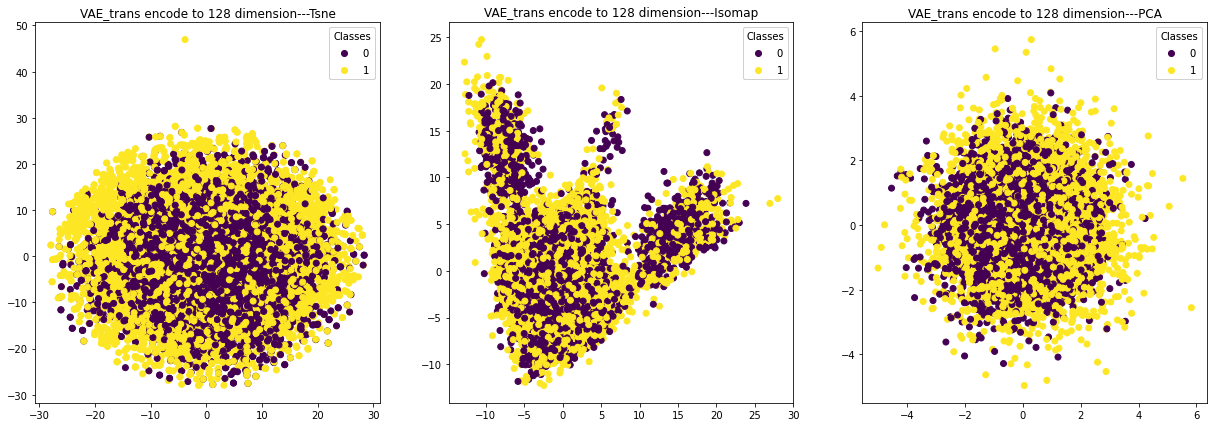

In [13]:
plot_decompose(z, y_test[0:10000])

In [ ]:
np.load(DATA_PROJECT+'vae_encode_tsne.npy').shape

In [ ]:
while True:
  pass